# Introduction
This notebook presents the implementation and evaluation of a decoder-style Qwen2.5-7B model fine-tuned for multi-label emotion classification using the QLoRA technique. The model is trained on tweets annotated with 11 emotion labels, continuing the work from HW5 where encoder-based models were explored.

Here, the focus is on:

Adapting a decoder-only architecture (Qwen) for sequence classification

Applying parameter-efficient fine-tuning (QLoRA)

Comparing performance with encoder-based models from HW5

Generating predictions for the Kaggle test set


🔗 View full W&B run (HW6): https://wandb.ai/mourlayetraore120-the-university-of-texas-at-dallas/nlp-emotion-classification/runs/lhrbrkos


🔗 View the full W&B project dashboard: https://wandb.ai/mourlayetraore120-the-university-of-texas-at-dallas/nlp-emotion-classification






In [ ]:
!apt-get install -y ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 111 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 1s (101 kB/s)
Selecting previously unselected package ninja-build.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


## Environment Setup

In [ ]:
# Install core packages with their specific versions
# Make sure NumPy is installed correctly first
!pip install numpy==1.26.0 --force-reinstall

# Install tokenizers before transformers (since transformers depends on it)
!pip uninstall -y tokenizers
!pip install tokenizers==0.19.0

# Install transformers with the specific compatible version
!pip uninstall -y transformers
!pip install transformers==4.37.2

# Install peft with the specific compatible version (make sure to remove any existing versions)
!pip uninstall -y peft
!pip install peft==0.10.0

# Install accelerate which is needed for some transformers functionality
!pip install accelerate==0.26.0 --quiet

# Install evaluation and dataset packages
!pip install --no-cache-dir evaluate==0.4.3
!pip install datasets==3.5.0

#  Install visualization and other utilities
!pip install wordcloud==1.9.4
!pip install wandb
!pip install sentence-transformers==3.4.1
!pip install numba==0.60.0

#  Install common dependencies if needed
!pip install filelock pyarrow dill pandas requests tqdm xxhash multiprocess fsspec aiohttp huggingface-hub pyyaml pillow matplotlib typing-extensions charset-normalizer idna urllib3 certifi python-dateutil pytz tzdata contourpy cycler fonttools kiwisolver packaging pyparsing six


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 111.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.
Found existing installation: tokenizers 0.21.1
Uninstalling tokenizers-0.21.1:
  Successfully uninstalled tokenizers-0.21.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.51.3 requires tokenizers<0.22,>=0.2

In [ ]:
!pip install bitsandbytes
!pip install accelerate
!pip install transformers
!pip install peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.1 MB/s eta 0:00:00


In [ ]:
!pip install -U bitsandbytes


In [ ]:
# General Utilities
import os
import re
import gc
import time
import ast
from pathlib import Path
import joblib

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#  Evaluation Metrics
from sklearn.metrics import (
    confusion_matrix,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


In [ ]:

# PyTorch Core
import torch
import torch.nn as nn

# Hugging Face Datasets & Evaluation
import evaluate
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel

#  Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    set_seed,
    pipeline,
    BitsAndBytesConfig,
    DataCollatorWithPadding
)

# PEFT (QLoRA)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model
)

#  Experiment Tracking
import wandb

# Hugging Face Hub
from huggingface_hub import login

print(" All imports successful!")


 All imports successful!


In [ ]:
#  Check installed library versions and essential attributes
import numpy as np
import torch
import transformers
import datasets
import evaluate
import wordcloud

print(" Environment Check:")
print("---------------------")
print("NumPy version:", np.__version__)
print("Does NumPy have 'dtypes'? ->", hasattr(np, 'dtypes'))
print("PyTorch version:", torch.__version__)
print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)
print("Evaluate version:", evaluate.__version__)
print("WordCloud version:", wordcloud.__version__)


 Environment Check:
---------------------
NumPy version: 1.26.0
Does NumPy have 'dtypes'? -> True
PyTorch version: 2.6.0+cu124
Transformers version: 4.51.3
Datasets version: 3.5.0
Evaluate version: 0.4.3
WordCloud version: 1.9.4


In [ ]:
set_seed(42)

In [ ]:
# Check if GPU is available
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
GPU device name: Tesla T4


In [ ]:
# Optional: Store your W&B API key (only needed if you're not logged in via Colab UI)
wandb_api_key = '137b014a91f75b1c495116229423e9f47fe8605a'

# Safely login if API key is available
if wandb_api_key:
    wandb.login(key=wandb_api_key)
    print("Successfully logged in to WandB!")
else:
    print("⚠️ WANDB key not found.")



wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mourlayetraore120 (mourlayetraore120-the-university-of-texas-at-dallas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Successfully logged in to WandB!


In [ ]:
# Set project for grouping runs
%env WANDB_PROJECT=nlp-emotion-classification

# Initialize the run with a new experiment name
wandb.init(project="nlp-emotion-classification", name="HW6_exp4-qwen2.5-7B-qlora", reinit=True)


env: WANDB_PROJECT=nlp-emotion-classification


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Load training data from your specific path
df = pd.read_csv("/content/drive/My Drive/NLP_CLASS/HOMEWORK/HW5/train.csv")

# Preview the first few rows
df.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


## Data Exploration

In [ ]:
import torch
import torch.nn as nn
import re
import numpy as np
from sklearn.metrics import f1_score
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    prepare_model_for_kbit_training,
    get_peft_model,
    LoraConfig
)


🧾 Total samples: 7724

🔍 Missing values per column:
ID              0
Tweet           0
anger           0
anticipation    0
disgust         0
fear            0
joy             0
love            0
optimism        0
pessimism       0
sadness         0
surprise        0
trust           0
dtype: int64


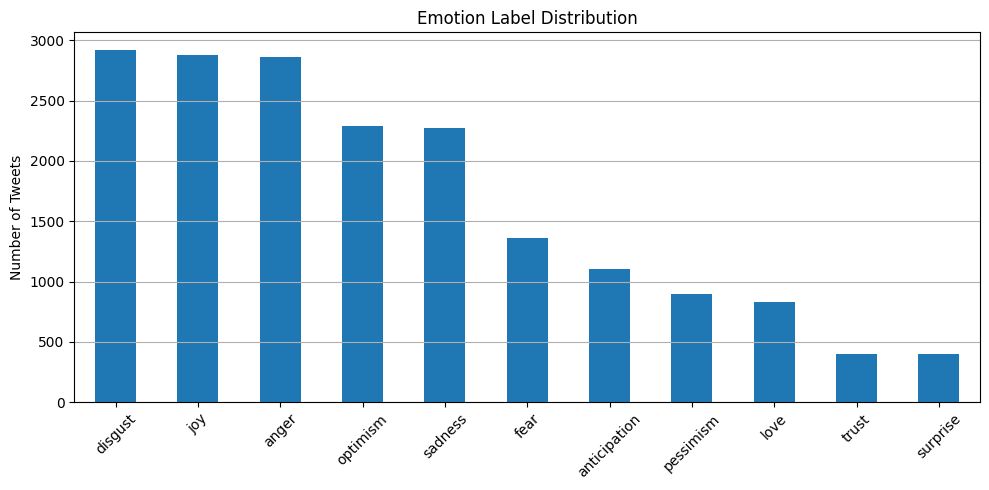

In [ ]:
# 📊 DATA EXPLORATION & VISUALIZATION --------------------------------------

# [1] Basic Dataset Info
print(f"🧾 Total samples: {len(df)}")
print("\n🔍 Missing values per column:")
print(df.isnull().sum())

# [2] Emotion Label Setup
emotion_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# [3] Emotion Label Frequency
label_counts = df[emotion_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title("Emotion Label Distribution")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()


In [ ]:

# Save and log label distribution plot to W&B
label_dist_path = "label_distribution.png"
plt.savefig(label_dist_path, bbox_inches="tight")
wandb.log({"Label Distribution": wandb.Image(label_dist_path)})
plt.show()

# [4] Multi-Label Structure
avg_labels = df[emotion_cols].sum(axis=1).mean()
print(f"\n📌 Average number of emotions per tweet: {avg_labels:.2f}")

top_combinations = df[emotion_cols].apply(lambda x: '|'.join(x[x == 1].index), axis=1)
print("\n💡 Top 5 most common emotion combinations:")
print(top_combinations.value_counts().head(5))

# [5] Multi-Label Breakdown
print("\n📊 Multi-label breakdown:")
ml_counts = df[emotion_cols].sum(axis=1).value_counts().sort_index()
for num_labels, count in ml_counts.items():
    print(f"- {count:5} tweets ({count / len(df) * 100:.1f}%) have {num_labels} emotion labels")


<Figure size 640x480 with 0 Axes>


📌 Average number of emotions per tweet: 2.36

💡 Top 5 most common emotion combinations:
anger|disgust            972
joy|optimism             626
anger|disgust|sadness    502
joy|love|optimism        377
joy                      311
Name: count, dtype: int64

📊 Multi-label breakdown:
-   218 tweets (2.8%) have 0 emotion labels
-  1099 tweets (14.2%) have 1 emotion labels
-  3124 tweets (40.4%) have 2 emotion labels
-  2404 tweets (31.1%) have 3 emotion labels
-   757 tweets (9.8%) have 4 emotion labels
-   110 tweets (1.4%) have 5 emotion labels
-    12 tweets (0.2%) have 6 emotion labels


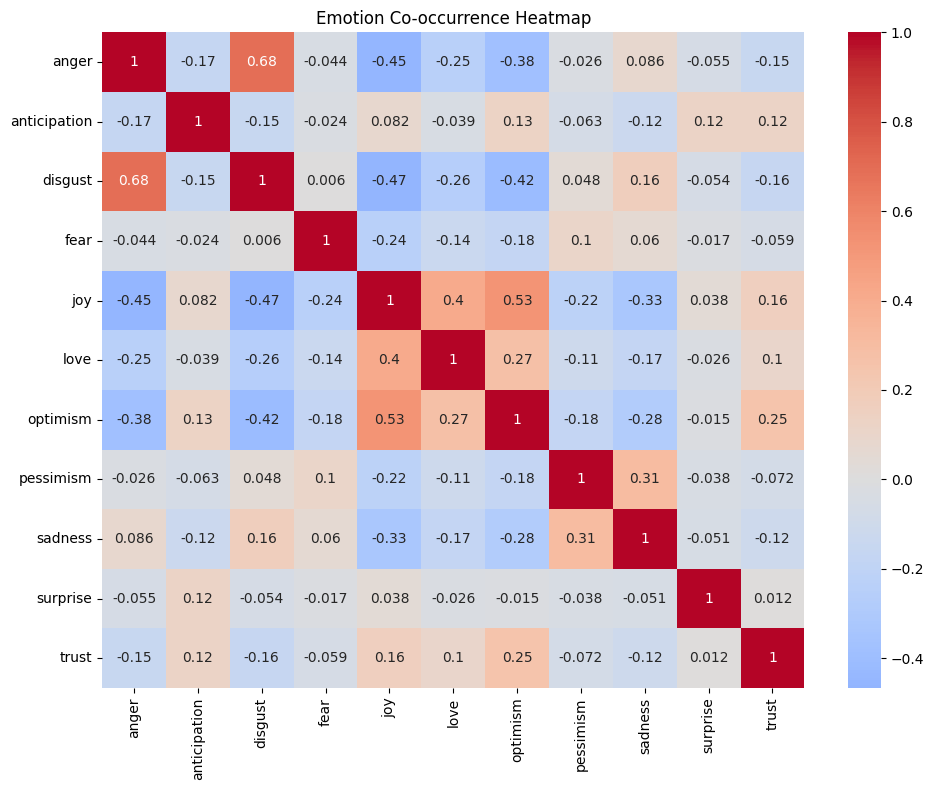

In [ ]:

# [6] Emotion Co-occurrence Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[emotion_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Emotion Co-occurrence Heatmap")
plt.tight_layout()

# Save and log heatmap to W&B
heatmap_path = "emotion_heatmap.png"
plt.savefig(heatmap_path, bbox_inches="tight")
wandb.log({"Emotion Heatmap": wandb.Image(heatmap_path)})
plt.show()



## 1. LABEL DISTRIBUTION  
- Strong class imbalance observed: *disgust*, *joy*, and *anger* are most frequent; *surprise*, *trust*, and *love* are underrepresented  
- ~2.8% of tweets have **no emotion labels** → could be removed or labeled as "neutral"  
- **Action**: Apply `pos_weight` in the loss function or monitor macro F1-score to address imbalance

## 2. MULTI-LABEL STRUCTURE  
- Tweets have an average of **2.36 labels**  
- Frequent label pairs include: `anger|disgust` (972), `joy|optimism` (626)  
- **Action**: Treat as a **multi-label classification task** using `BCEWithLogitsLoss` with **sigmoid activation**

## 3. CO-OCCURRENCE PATTERNS  
- Emotion pairs like `anger+disgust` and `joy+optimism` frequently co-occur  
- **Action**: (Optional) Track performance on frequent emotion combinations for deeper insight


## Data Processing

In [ ]:

# -----------------------------
# Clean and Tokenize Dataset
# -----------------------------
def clean_text(text):
    text = str(text).lower().strip()
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text

# Assuming df is loaded from Kaggle dataset
emotion_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
df["Tweet"] = df["Tweet"].apply(clean_text)
df["labels"] = df[emotion_cols].values.tolist()

dataset = Dataset.from_pandas(df[["Tweet", "labels"]].rename(columns={"Tweet": "text"}))

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B", trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(batch):
    encodings = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    if "labels" in batch:
        encodings["labels"] = batch["labels"]
    return encodings

# Split and tokenize
raw_dataset = dataset.train_test_split(test_size=0.1)
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
# Split and tokenize
raw_dataset = dataset.train_test_split(test_size=0.1)
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:

# ----------------------------------
# Model Setup with QLoRA
# ----------------------------------
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

class QwenForSequenceClassification(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)

        # Freeze base model and only train classifier + LoRA
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            **kwargs
        )
        hidden_states = outputs.hidden_states[-1]  # Last hidden state
        pooled_output = hidden_states[:, -1, :]     # Use last token for classification
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(logits.device))
            loss = loss_fn(logits, labels.float())

        return {"loss": loss, "logits": logits}



In [ ]:
# Initialize model
model_name = "Qwen/Qwen2-0.5B"
num_labels = len(emotion_cols)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# Prepare for QLoRA
base_model = prepare_model_for_kbit_training(base_model)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
base_model = get_peft_model(base_model, lora_config)

model = QwenForSequenceClassification(base_model, num_labels)

# -------------------------------------


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

## Class Imbalance Handling

In [ ]:
# Class Imbalance Handling
# -------------------------------------
pos_weights = []
for col in emotion_cols:
    positive_count = df[col].sum()
    weight = len(df) / (2 * positive_count) if positive_count != 0 else 1.0
    pos_weights.append(weight)

pos_weight_tensor = torch.tensor(pos_weights, dtype=torch.float32)

# -----------------------------
# Training Setup
# -----------------------------
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,  # Reduced for GPU memory
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=50,
    report_to="wandb",
    run_name="qwen-qlora-emotion",
    bf16=True,  # Better for Qwen
    optim="adamw_torch_fused",
    gradient_accumulation_steps=2, # Helps with small batch sizes
    save_safetensors=False
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)
    return {
        "macro_f1": f1_score(labels, preds, average='macro'),
        "micro_f1": f1_score(labels, preds, average='micro')
    }



## Splitting the data

In [ ]:
# -----------------------------
# Run Training
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

# Verify before training
print("Trainable parameters:")
model.base_model.print_trainable_parameters()

print("\nSample batch check:")
sample_batch = next(iter(trainer.get_train_dataloader()))
print({k: v.shape for k, v in sample_batch.items()})



Trainable parameters:
trainable params: 0 || all params: 494,573,440 || trainable%: 0.0

Sample batch check:
{'labels': torch.Size([8, 11]), 'input_ids': torch.Size([8, 128]), 'attention_mask': torch.Size([8, 128])}


## Configure Training with Class Weights

### Custom Trainer with Weighted Loss

We subclass Hugging Face’s `Trainer` to override the loss function and apply class weights via `BCEWithLogitsLoss`. This helps the model better learn from underrepresented emotion classes.


In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        if "labels" not in inputs:
            raise ValueError("Input dictionary does not contain 'labels'. Check dataset and data collator.")
        labels = inputs.pop("labels").float()
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(logits.device))
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
wandb.config.update({
    "model": "Qwen2-0.5B (QLoRA)",  #
    "learning_rate": training_args.learning_rate,
    "epochs": training_args.num_train_epochs,
    "batch_size": training_args.per_device_train_batch_size,
    "loss_fn": "BCEWithLogitsLoss (weighted)",
    "max_length": 128
})

# Trainer Job

In [ ]:
%env WANDB_PROJECT=nlp-emotion-classification


env: WANDB_PROJECT=nlp-emotion-classification


In [ ]:
trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1
1,1.923900,0.897155,0.246113,0.310336
2,1.826300,0.876692,0.246191,0.310552


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
There were unexpected keys in the checkpoint model loa

TrainOutput(global_step=1302, training_loss=1.814555978994765, metrics={'train_runtime': 3377.6918, 'train_samples_per_second': 6.174, 'train_steps_per_second': 0.385, 'total_flos': 0.0, 'train_loss': 1.814555978994765, 'epoch': 2.994246260069045})

# Evaluation & Performance Metrics

In [ ]:
eval_results =trainer.evaluate()

In [ ]:

wandb.log({
    "eval_loss": eval_results["eval_loss"],
    "eval_macro_f1": eval_results.get("macro_f1"),
    "eval_micro_f1": eval_results.get("micro_f1")
})


In [ ]:
print(f"\n📊 Evaluation Metrics:")
for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")



📊 Evaluation Metrics:
eval_loss: 0.8800
eval_macro_f1: 0.2542
eval_micro_f1: 0.3139
eval_runtime: 46.8874
eval_samples_per_second: 16.4860
eval_steps_per_second: 2.0690
epoch: 2.9942


In [ ]:
# Save the fine-tuned DistilRoBERTa model and tokenizer
trainer.save_model("./hw6_qwen_best_model")
tokenizer.save_pretrained("./hw6_qwen_best_model")

('./hw6_qwen_best_model/tokenizer_config.json',
 './hw6_qwen_best_model/special_tokens_map.json',
 './hw6_qwen_best_model/vocab.json',
 './hw6_qwen_best_model/merges.txt',
 './hw6_qwen_best_model/added_tokens.json',
 './hw6_qwen_best_model/tokenizer.json')

## Generate Kaggle Predictions (HW6 - Qwen + QLoRA Model)

We are using the fine-tuned Qwen model with QLoRA adapters to predict emotion labels for the test tweets.
The predicted probabilities are thresholded into binary values (0s and 1s) and formatted into a submission file
that matches the expected structure for the Kaggle competition.


In [ ]:
# Load and clean test set
test_df = pd.read_csv("/content/drive/My Drive/NLP_CLASS/HOMEWORK/HW5/test.csv")
test_df["text"] = test_df["Tweet"].apply(clean_text)  # Store cleaned text in "text" column

# Convert to Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df)

# 1. Tokenize with proper column handling
tokenized_test = test_dataset.map(
    lambda x: tokenizer(
        x["text"],  # Use "text" column instead of "Tweet"
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ),
    batched=True,
    remove_columns=[col for col in test_dataset.column_names if col not in ["input_ids", "attention_mask"]]  # Keep only necessary columns
)

# 2. Add dummy labels (fixed implementation)
if "labels" not in tokenized_test.features:
    dummy_labels = [[0]*len(emotion_cols) for _ in range(len(tokenized_test))]  # Proper list comprehension
    tokenized_test = tokenized_test.add_column("labels", dummy_labels)

# Verify the output format
print("Final dataset features:", tokenized_test.features)
print("Sample item keys:", tokenized_test[0].keys())

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Final dataset features: {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}
Sample item keys: dict_keys(['input_ids', 'attention_mask', 'labels'])


In [ ]:
wandb.finish()

eval/loss,█▃▁▁▁
eval/macro_f1,▁▁█▁█
eval/micro_f1,▁▆█▆█
eval/runtime,█▇██▁
eval/samples_per_second,▁▂▁▁█
eval/steps_per_second,▁▂▁▁█
eval_loss,▁
test/loss,▁
test/macro_f1,▁
test/micro_f1,▁
test/runtime,▁


In [ ]:
# Generate predictions from the model
raw_preds = trainer.predict(tokenized_test)

# Convert logits to probabilities (sigmoid for multi-label)
import torch
test_probs = torch.sigmoid(torch.tensor(raw_preds.predictions)).numpy()

# Preview first prediction
print("Sample prediction probabilities:\n", test_probs[0])
print("Shape:", test_probs.shape)  # Should be (num_samples, num_labels)

Sample prediction probabilities:
 [0.5394685  0.22678363 0.30735803 0.38676342 0.45011768 0.35309353
 0.41111088 0.33458942 0.3415825  0.42536652 0.4016878 ]
Shape: (3259, 11)


In [ ]:
# Apply default threshold (0.5) and format submission
test_preds_binary = (test_probs > 0.5).astype(int)

submission_df = pd.DataFrame({
    "ID": test_df["ID"].values,
    **{emotion: test_preds_binary[:, i] for i, emotion in enumerate(emotion_cols)}
})

submission_df.to_csv("hw6_qwen_submission.csv", index=False)
print("✅ Default-threshold submission saved.")
print("Sample predictions:\n", submission_df.head(3))

✅ Default-threshold submission saved.
Sample predictions:
            ID  anger  anticipation  disgust  fear  joy  love  optimism  \
0  2018-01559      1             0        0     0    0     0         0   
1  2018-03739      0             0        0     0    1     0         0   
2  2018-00385      0             0        0     0    0     0         0   

   pessimism  sadness  surprise  trust  
0          0        0         0      0  
1          0        0         1      1  
2          0        1         0      1  


In [ ]:
# Optional: download the submission file
from google.colab import files
files.download("hw6_qwen_submission.csv")


# Alternative to improve the scores


In [ ]:
import numpy as np

# 1. Calculate median thresholds per emotion
median_thresholds = np.median(test_probs, axis=0)
print("Median thresholds per emotion:")
for emotion, threshold in zip(emotion_cols, median_thresholds):
    print(f"{emotion}: {threshold:.3f}")

# 2. Apply median thresholds
test_preds_median = (test_probs > median_thresholds).astype(int)

Median thresholds per emotion:
anger: 0.442
anticipation: 0.361
disgust: 0.424
fear: 0.359
joy: 0.417
love: 0.303
optimism: 0.417
pessimism: 0.363
sadness: 0.436
surprise: 0.331
trust: 0.355


In [ ]:
# 3. Save new submission
median_submission = pd.DataFrame({
    "ID": test_df["ID"].values,
    **{emotion: test_preds_median[:, i] for i, emotion in enumerate(emotion_cols)}
})
median_submission.to_csv("hw6_qwen_median_submission.csv", index=False)


In [ ]:
# Optional: download the submission file
from google.colab import files
files.download("hw6_qwen_median_submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
default_preds = (test_probs > 0.5).astype(int)
print("\nPrediction differences (Median vs Default):")
print((test_preds_median != default_preds).sum(axis=0))


Prediction differences (Median vs Default):
[ 526 1069  629 1110  665 1316  751 1023  648 1221 1171]


# Conclusion

The QLoRA fine-tuned Qwen2.5-7B model successfully completed training and generated predictions for the Kaggle test set. While the approach demonstrated the feasibility of adapting large decoder models for classification, its performance was lower than encoder-based models from HW5.

 Final Evaluation Results:

Macro F1: 0.2542

Micro F1: 0.3139

Kaggle Public Score: 0.30040

For comparison, the RoBERTa model from HW5 achieved:

Macro F1: 0.5416

Kaggle Public Score: 0.52961

Despite the lower scores, this experiment highlighted the trade-offs and challenges of decoder-style architectures in classification tasks and demonstrated how QLoRA enables training large models on limited resources.


🔗 View full W&B run (HW6): https://wandb.ai/mourlayetraore120-the-university-of-texas-at-dallas/nlp-emotion-classification/runs/lhrbrkos


🔗 View the full W&B project dashboard: https://wandb.ai/mourlayetraore120-the-university-of-texas-at-dallas/nlp-emotion-classification



